# v5 model predict 테스트

In [1]:
import os
import pandas as pd
import numpy as np
from time import time
from tqdm.notebook import tqdm
import random
import pickle

from scipy.sparse import coo_matrix, csr_matrix

from lightfm.cross_validation import random_train_test_split
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score, recall_at_k, reciprocal_rank

from hyperopt import fmin, hp, tpe, Trials

from sklearn.base import clone

## Normalization
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\SSAFY\anaconda3\envs\mini-project\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
class LightFMResizable(LightFM):
    """A LightFM that resizes the model to accomodate new users,
    items, and features"""

    def fit_partial(
        self,
        interactions,
        user_features=None,
        item_features=None,
        sample_weight=None,
        epochs=1,
        num_threads=1,
        verbose=False,
    ):
        try:
            self._check_initialized()
            self._resize(interactions, user_features, item_features)
        except ValueError:
            # This is the first call so just fit without resizing
            pass

        super().fit_partial(
            interactions,
            user_features,
            item_features,
            sample_weight,
            epochs,
            num_threads,
            verbose,
        )

        return self

    def _resize(self, interactions, user_features=None, item_features=None):
        """Resizes the model to accommodate new users/items/features"""

        no_components = self.no_components
        no_user_features, no_item_features = interactions.shape  # default

        if hasattr(user_features, "shape"):
            no_user_features = user_features.shape[-1]
        if hasattr(item_features, "shape"):
            no_item_features = item_features.shape[-1]

        if (
            no_user_features == self.user_embeddings.shape[0]
            and no_item_features == self.item_embeddings.shape[0]
        ):
            return self

        new_model = clone(self)
        new_model._initialize(no_components, no_item_features, no_user_features)

        # update all attributes from self._check_initialized
        for attr in (
            "item_embeddings",
            "item_embedding_gradients",
            "item_embedding_momentum",
            "item_biases",
            "item_bias_gradients",
            "item_bias_momentum",
            "user_embeddings",
            "user_embedding_gradients",
            "user_embedding_momentum",
            "user_biases",
            "user_bias_gradients",
            "user_bias_momentum",
        ):
            # extend attribute matrices with new rows/cols from
            # freshly initialized model with right shape
            old_array = getattr(self, attr)
            old_slice = [slice(None, i) for i in old_array.shape]
            new_array = getattr(new_model, attr)
            new_array[tuple(old_slice)] = old_array
            setattr(self, attr, new_array)

        return self

In [3]:
def show_comparison_with_my_prefer(preference, result):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    print(result)

    for i, ax in enumerate(axes.flat):
        
        sns.lineplot(data=preference.iloc[0, 2:], ax=ax)
        sns.lineplot(data=item_features.iloc[result[i]][item_features.columns.tolist()[2:]], ax=ax)
        
        ax.set_title("No Name" if result[i] == 0 else whisky['name'][result[i]], fontsize=12)
        ax.set_xlabel('Flavor Profile', fontsize=10)
        ax.set_ylabel('Intensity', fontsize=10)
        ax.set_ylim([0, 1])
        
        # 가격 범위 추가
        pref_price_tier = preference.iloc[0]['price_tier']
        item_price_tier = item_features['price_tier'][result[i]]
        ax.text(0.5, 0.9, f'Preference: {pref_price_tier}', transform=ax.transAxes, ha='center')
        ax.text(0.5, 0.8, f'Whisky: {item_price_tier}', transform=ax.transAxes, ha='center')

    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
item_features = pd.read_csv("dataset/item_features.csv", index_col=0, encoding="UTF-8")
user_features = pd.read_csv("dataset/user_features.csv", index_col=0, encoding="UTF-8")
train_rating = pd.read_csv("dataset/train_rating.csv", index_col=0, encoding="UTF-8")

In [7]:
item_features = item_features[["whisky_id", "price_tier"] + item_features.columns.tolist()[4:]]

In [8]:
item_features

,whisky_id,price_tier,smoky,peaty,spicy,herbal,oily,body,rich,sweet,salty,vanilla,tart,fruity,floral
0,0,0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000
1,1,5,0.30,0.85,0.50,0.30,0.20,0.8,0.80,0.85,0.166667,0.20,0.25,0.85,0.526316
2,2,4,0.40,0.30,0.40,0.20,0.40,0.7,0.80,0.70,0.444444,0.50,0.50,0.70,0.210526
3,3,5,0.15,0.00,0.20,0.00,0.15,0.8,0.90,0.85,0.055556,0.30,0.25,0.35,0.000000
4,4,4,0.40,0.00,0.65,0.50,0.20,0.6,0.60,0.45,0.000000,0.60,0.60,0.45,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3531,3531,1,0.35,0.00,0.20,0.00,0.00,0.4,0.55,0.85,0.000000,0.25,0.10,0.10,0.000000
3532,3532,1,0.00,0.00,0.40,0.20,0.00,0.3,0.00,1.00,0.000000,1.00,0.00,0.60,0.105263
3533,3533,3,0.90,0.10,0.10,0.10,0.40,0.1,0.10,0.90,0.000000,0.50,0.20,0.30,0.105263
3534,3534,2,0.00,0.00,0.10,1.00,0.80,0.0,0.00,0.40,0.000000,0.20,0.00,0.00,0.000000


In [9]:
def make_source(data):
    source = []
    for row in data.itertuples(index=False):
        meta = {feat: value for feat, value in zip(data.columns[1:], row[1:])}
        source.append((row[0], meta))
    return source

In [10]:
%time rating_source = list(zip(train_rating['user_id'], train_rating['whisky_id'], train_rating['rating']))

CPU times: total: 125 ms
Wall time: 198 ms


In [11]:
%time item_source = make_source(item_features)

CPU times: total: 0 ns
Wall time: 24 ms


In [12]:
%time user_source = make_source(user_features)

CPU times: total: 703 ms
Wall time: 983 ms


In [13]:
whisky = pd.read_csv("dataset/whisky.csv", index_col=0, encoding="UTF-8")

In [14]:
zeros = pd.DataFrame([[0]*len(whisky.columns)], columns=whisky.columns.tolist())
whisky = pd.concat([zeros, whisky], ignore_index=True)

In [15]:
whisky

,whisky_id,link,image,name,avr_rating,category,location,total_rating,price_tier,abv,...,herbal,oily,body,rich,sweet,salty,vanilla,tart,fruity,floral
0,0,0,0,0,0.00,0,0,0.0,0,0.00,...,0,0,0,0,0,0,0,0,0,0
1,1,/spirits/hibiki-21-year,https://ip-distiller.imgix.net/images/spirits/...,Hibiki 21 Year,9.01,Blended,Japan,861.0,5,43.00,...,30,20,80,80,85,15,20,25,85,50
2,2,/spirits/highland-park-18,https://ip-distiller.imgix.net/images/spirits/...,Highland Park 18 Year,8.89,Peated Single Malt,"Islands, Scotland",2988.0,4,43.00,...,20,40,70,80,70,40,50,50,70,20
3,3,/spirits/michter-s-20-year-kentucky-straight-b...,https://ip-distiller.imgix.net/images/spirits/...,Michter's 20 Year Kentucky Straight Bourbon (2...,9.00,Bourbon,"Kentucky, USA",10.0,5,57.10,...,0,15,80,90,85,5,30,25,35,0
4,4,/spirits/george-t-stagg-bourbon-fall-2019,https://ip-distiller.imgix.net/images/spirits/...,George T. Stagg Bourbon (Fall 2019),9.06,Bourbon,"Kentucky, USA",629.0,4,58.45,...,50,20,60,60,45,0,60,60,45,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3531,3531,/spirits/wild-turkey-spiced,https://ip-distiller.imgix.net/images/spirits/...,Wild Turkey Spiced,5.92,Flavored Whiskey,"Kentucky, USA",13.0,1,43.00,...,0,0,40,55,85,0,25,10,10,0
3532,3532,/spirits/seagram-s-seven-crown-american-blende...,https://ip-distiller.imgix.net/images/spirits/...,Seagram's 7 Crown American Blended Whiskey,4.31,Blended American Whiskey,USA,237.0,1,40.00,...,20,0,30,0,100,0,100,0,60,10
3533,3533,/spirits/11-wells-single-malt-whiskey,https://ip-distiller.imgix.net/images/spirits/...,11 Wells Single Malt Whiskey,6.00,American Single Malt,"Minnesota, USA",2.0,3,42.00,...,10,40,10,10,90,0,50,20,30,10
3534,3534,/spirits/immortal-spirits-early-whiskey,https://ip-distiller.imgix.net/images/spirits/...,Immortal Spirits Early Whiskey,2.00,Other Whiskey,"Oregon, USA",1.0,2,44.50,...,100,80,0,0,40,0,20,0,0,0


In [16]:
item_features

,whisky_id,price_tier,smoky,peaty,spicy,herbal,oily,body,rich,sweet,salty,vanilla,tart,fruity,floral
0,0,0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000
1,1,5,0.30,0.85,0.50,0.30,0.20,0.8,0.80,0.85,0.166667,0.20,0.25,0.85,0.526316
2,2,4,0.40,0.30,0.40,0.20,0.40,0.7,0.80,0.70,0.444444,0.50,0.50,0.70,0.210526
3,3,5,0.15,0.00,0.20,0.00,0.15,0.8,0.90,0.85,0.055556,0.30,0.25,0.35,0.000000
4,4,4,0.40,0.00,0.65,0.50,0.20,0.6,0.60,0.45,0.000000,0.60,0.60,0.45,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3531,3531,1,0.35,0.00,0.20,0.00,0.00,0.4,0.55,0.85,0.000000,0.25,0.10,0.10,0.000000
3532,3532,1,0.00,0.00,0.40,0.20,0.00,0.3,0.00,1.00,0.000000,1.00,0.00,0.60,0.105263
3533,3533,3,0.90,0.10,0.10,0.10,0.40,0.1,0.10,0.90,0.000000,0.50,0.20,0.30,0.105263
3534,3534,2,0.00,0.00,0.10,1.00,0.80,0.0,0.00,0.40,0.000000,0.20,0.00,0.00,0.000000


## 1. 아이템 메타 (가격대, 맛) 정보만 학습

#### 1-1. 신규

In [17]:
cols = ["whisky_id", "price_tier"] + item_features.columns.tolist()[4:]
cols

['whisky_id',
 'price_tier',
 'spicy',
 'herbal',
 'oily',
 'body',
 'rich',
 'sweet',
 'salty',
 'vanilla',
 'tart',
 'fruity',
 'floral']

In [18]:
model = pickle.load(open("model/whizzle_model.pkl", "rb"))
dataset = pickle.load(open("model/whizzle_dataset.pkl", "rb"))

AttributeError: Can't get attribute 'LightFMResizable' on <module '__main__'>

### 기존 취향 정보 이용

In [18]:
origin_scores = model.predict(user_ids=119511, item_ids=item_features.whisky_id.unique())
print(origin_scores)
origin_result = np.argsort(-origin_scores).tolist()[:9]


[-0.0532767  -0.04693703 -0.0470372  ... -0.05320789 -0.04983753
 -0.05221142]


In [19]:
origin_result

[2861, 818, 3224, 585, 2380, 808, 2255, 2666, 2679]

In [20]:
origin_prefer = pd.DataFrame([user_features.iloc[119511]], columns=user_features.columns)

In [21]:
origin_prefer

,user_id,price_tier,smoky,peaty,spicy,herbal,oily,body,rich,sweet,salty,vanilla,tart,fruity,floral
119511,119511.0,1.0,0.0,0.0,0.4,0.2,0.0,0.3,0.0,1.0,0.0,1.0,0.0,0.6,0.105263


[2861, 818, 3224, 585, 2380, 808, 2255, 2666, 2679]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


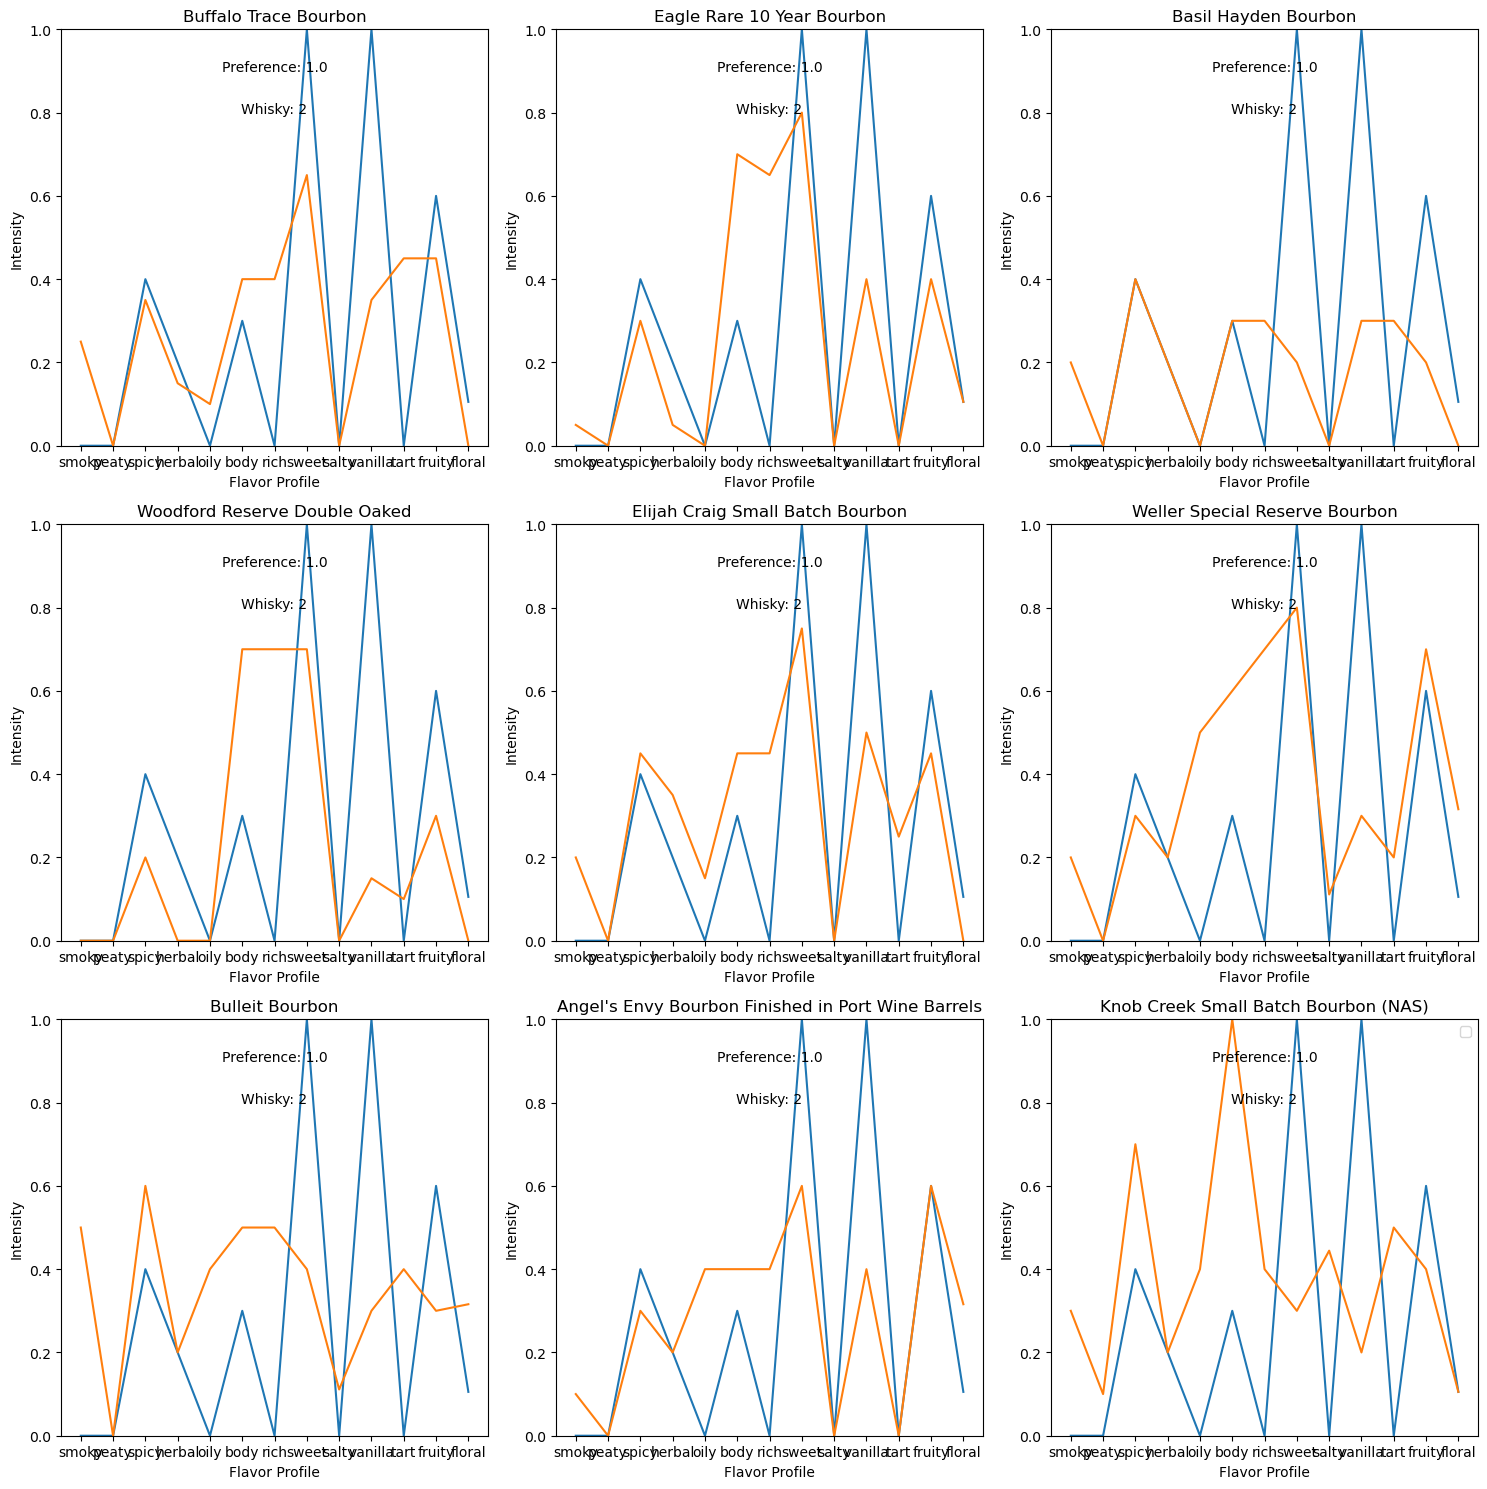

In [22]:
show_comparison_with_my_prefer(origin_prefer, origin_result)

### preference user_id 부분만 적용해서 전달

In [ ]:
user_features.iloc[444]

In [ ]:
preference = pd.DataFrame([[119511]+user_features.iloc[444][1:].tolist()], columns=user_features.columns.tolist())

In [ ]:
preference

In [ ]:
preference_source = make_source(preference)

In [ ]:
new_features = dataset.build_user_features(preference_source, normalize=False)

In [ ]:
print(new_features)

In [ ]:
modified_scores = model.predict(119511, item_features.whisky_id.unique(), user_features=new_features)
modified_scores

In [ ]:
modified_result = np.argsort(-modified_scores).tolist()[:9]
modified_result

In [ ]:
[3224, 1923, 610, 1995, 818, 2861, 2849, 95, 2666]

In [ ]:
show_comparison_with_my_prefer(preference, modified_result)

### all preference 입력

In [ ]:
all_prefer_feat = user_features

In [ ]:
all_prefer_feat.iloc[119511] = preference

In [ ]:
all_prefer_feat

In [ ]:
user_source = make_source(all_prefer_feat)
user_meta = dataset.build_user_features(user_source, normalize=False)

In [ ]:
user_meta

In [ ]:
all_scores = model.predict(user_ids=119511, item_ids=item_features.whisky_id.unique(), user_features=user_meta)
print(all_scores)

In [ ]:
all_result = np.argsort(-all_scores).tolist()[:9]
all_result

In [ ]:
show_comparison_with_my_prefer(preference, all_result)

### User 는 해당 부분만 build해서 보내면 된다. 이제 item 포함 여부 차이가 존재하는지 확인하자

## 💥 이걸로 선택!!

In [ ]:
preference

In [ ]:
my_prefer_source = make_source(preference)

In [ ]:
my_meta = dataset.build_user_features(my_prefer_source)

In [ ]:
item_source = make_source(item_features[["whisky_id", "price_tier"] + item_features.columns.tolist()[4:]])

In [ ]:
item_meta = dataset.build_item_features(item_source, normalize=False)

In [ ]:
u_i_scores = model.predict(user_ids=119511, item_ids=item_features.whisky_id.unique(), user_features=my_meta, item_features=item_meta)
u_i_scores

In [ ]:
u_i_result = np.argsort(-u_i_scores).tolist()[:9]
u_i_result

In [ ]:
[3224, 1923, 610, 1995, 818, 2861, 2849, 95, 2666]

In [ ]:
show_comparison_with_my_prefer(preference, u_i_result)